# Imports

In [111]:
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from uk_stemmer import UkStemmer

# Load data

In [2]:
bbc = pd.read_csv('./data/bbc-translated.csv')

bbc

,category,content,content_uk
0,tech,UK gets official virus alert site A rapid ale...,"Дані з програмного забезпечення, які працюють ..."
1,tech,Chip maker backs net phone calls Rich Templet...,Продавець фішки знову телефонує до Rich Tempto...
2,tech,Podcasters look to net money Nasa is doin...,"""Провідники,"" які працюють вдома, пам'ятають, ..."
3,tech,Looks and music to drive mobiles Mobile phone...,"Шуд і музика, щоб вести мобільні телефони, все..."
4,tech,A question of trust and technology A major go...,Питання довіри і технології Основного уряду бе...
...,...,...,...
2220,entertainment,Comic Morris returns with sitcom Comedian Chr...,Комікс Морріс повертається разом з комісом Ком...
2221,entertainment,Joy Division story to become film The life of...,"Історія про те, щоб стати плівкою пізнього Джо..."
2222,entertainment,Belle named best Scottish band Belle & Se...,Белл назвав найкращих шотландських гуртів Белл...
2223,entertainment,Branson show flops on US screens Entrepreneur...,Branson shows shows on US screes Enterneur Ser...


In [3]:
imdb = pd.read_csv('./data/imdb-translated.csv')

imdb

,review,sentiment,review_uk
0,"I just caught this on Showtime...ewwwwwww, not...",negative,Я щойно побачив це на сайті Showtime...wwwwwww...
1,A lonely depressed French boy Mathieu (Jeremie...,positive,Незабутній французький хлопчик Матіеу (Jermie ...
2,My wife spotted this film on the aisle at a lo...,negative,Моя дружина помітила цей фільм на одному прохо...
3,I watched this movie on HBO and I had a good t...,positive,Я дивився цей фільм на HBO і мав добрий час. <...
4,this movie is such a good movie shah ruck khan...,positive,"Цей фільм такий гарний фільм ""Шак хан"" робить ..."
...,...,...,...
4995,This Italian movie is basically a soap opera w...,negative,"Цей італійський фільм, по суті, є милом оперою..."
4996,"The movie is not that bad, Ringo Lam sucks. I ...",negative,"але фільм не настільки поганий, Рінго Лам відс..."
4997,A movie this dumb should never see the light o...,negative,"Фільм, цей німий, ніколи не повинен бачити сві..."
4998,"I first saw ""The Knowledge"" during a Thames Te...",positive,"Я вперше побачив "" Знання "" під час телевізійн..."


# English

## Generic functions

In [10]:
stemmer = nltk.stem.snowball.SnowballStemmer('english')

stopwords = nltk.corpus.stopwords.words('english')

num_re = re.compile(r'\d+')
words_re = re.compile(r'\w+')
html_re = re.compile('<.*?>')

def prepare_en(text: str) -> str:
    tokens = word_tokenize(text.lower())
    tokens = [re.sub(html_re, '', t) for t in tokens]
    tokens = [stemmer.stem(t) for t in tokens]
    tokens = [t for t in tokens if t not in punctuation]
    tokens = [t for t in tokens if t not in stopwords]
    tokens = [t for t in tokens if num_re.match(t) is None]
    tokens = [t for t in tokens if words_re.match(t) is not None]

    return ' '.join(tokens)

## Classification (IMDB)

In [11]:
imdb_en_data = imdb.review.apply(prepare_en).tolist()
imdb_en_data[:10]

["caught showtim ewwwwwww even fun bad movi kind way one lamest monster flick ever seen plus tv report movi annoy jerri past season survivor onli amus thing secret base hous fantasi island million movi tv show place locat l.a. area fulli expect mr roark tattoo come greet visitor tattoo gotten eaten snake might given movi oh well watch peopl stand scream five minut komodo cobra loom instead make run pretti funni especi becaus could realli tell scream empti spot comput anim would later paint monster near fell chair though flashback scene brought either cobra komodo normal size indestruct solid steel contain air hole drill would n't wire cage suffic lol guess could n't afford rent real komodo cobra rememb rent showtim seri movi",
 "lone depress french boy mathieu jeremi elkaim vacat summer meet fall love cedric gorgeous stephan rideau quiet slow veri frustrat movi one hand absorb realli felt two boy get annoy film constant keep flash around past present rhyme reason veri confus pointless 

In [15]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, min_df=.01)

vectorized = vectorizer.fit_transform(imdb_en_data).toarray()

vectorizer.get_feature_names_out().shape

/mnt/e/university/master/text_analysis-labs/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1565,)

In [16]:
vectorizer.get_feature_names_out()

array(['.', 'abandon', 'abil', ..., 'younger', 'youth', 'zombi'],
      dtype=object)

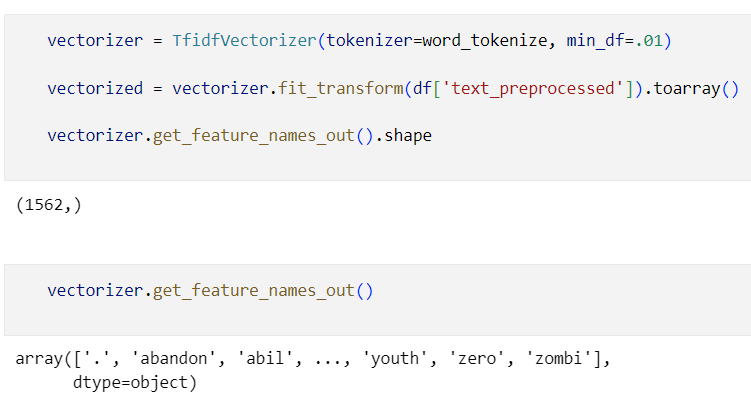

In [28]:
X_train_en_imdb, X_test_en_imdb, y_train_en_imdb, y_test_en_imdb = train_test_split(vectorized, imdb.sentiment.apply(lambda x: x == 'positive').to_numpy().astype(float))

In [29]:
X_train_en_imdb.shape, X_test_en_imdb.shape, X_train_en_imdb.shape, y_test_en_imdb.shape

((3750, 1565), (1250, 1565), (3750, 1565), (1250,))

### XGBoost

#### Single example

In [30]:
bst = XGBClassifier(n_estimators=200, max_depth=10, objective='binary:logistic')

bst.fit(X_train_en_imdb, y_train_en_imdb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
y_pred = bst.predict(X_test_en_imdb)

accuracy_score(y_test_en_imdb, y_pred), precision_score(y_test_en_imdb, y_pred), recall_score(y_test_en_imdb, y_pred), f1_score(y_test_en_imdb, y_pred)

(0.824, 0.7950413223140496, 0.8336221837088388, 0.8138747884940778)

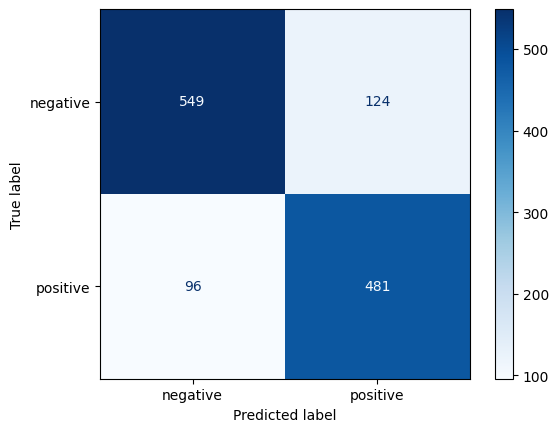

In [37]:
ConfusionMatrixDisplay.from_estimator(
        bst,
        X_test_en_imdb,
        y_test_en_imdb,
        display_labels=['negative', 'positive'],
        cmap=plt.cm.Blues,
    )

#### Generalize

In [115]:
def eval_xgboost(text_data: list[str], labels: np.ndarray, min_df:float=0.005, n_estimators:int=20, max_depth:int=5):
    vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None, min_df=min_df)
    X = vectorizer.fit_transform(text_data).toarray()
    y = labels
    n_tokens = len(vectorizer.get_feature_names_out())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    bst = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, objective='binary:logistic')
    start = time()
    bst.fit(X_train, y_train)
    time_took = time() - start

    y_pred = bst.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1, n_tokens, time_took, vectorizer, bst

In [47]:
configs = [
    {'min_df': .005, 'n_estimators': 2, 'max_depth': 3},
    {'min_df': .01, 'n_estimators': 2, 'max_depth': 3},
    {'min_df': .003, 'n_estimators': 2, 'max_depth': 3},
    {'min_df': .005, 'n_estimators': 10, 'max_depth': 3},
    {'min_df': .005, 'n_estimators': 2, 'max_depth': 7},
    {'min_df': .005, 'n_estimators': 100, 'max_depth': 3},
    {'min_df': .005, 'n_estimators': 200, 'max_depth': 3},
    {'min_df': .005, 'n_estimators': 100, 'max_depth': 5},
]

for conf in tqdm(configs):
    results = eval_xgboost(imdb_en_data, imdb.sentiment.apply(lambda x: x == 'positive').to_numpy().astype(float), **conf)
    conf['accuracy'] = results[0]
    conf['precision'] = results[1]
    conf['recall'] = results[2]
    conf['f1'] = results[3]
    conf['n_tokens'] = results[4]
    conf['time_took'] = results[5]
    conf['vectorizer'] = results[6]
    conf['bst'] = results[7]

 12%|███████████████▏                                                                                                         | 1/8 [00:02<00:17,  2.48s/it]/mnt/e/university/master/text_analysis-labs/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
 25%|██████████████████████████████▎                                                                                          | 2/8 [00:04<00:14,  2.41s/it]/mnt/e/university/master/text_analysis-labs/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
 38%|█████████████████████████████████████████████▍                                                                           | 3/8 [00:07<00:12,  2.57s/it]/mnt/e/university/master/text_analysis-labs/venv/lib/python3.10/site-packages/sk

#### Results

In [49]:
pd.DataFrame(configs).drop(columns=['vectorizer', 'bst'])

,min_df,n_estimators,max_depth,accuracy,precision,recall,f1,n_tokens,time_took
0,0.005,2,3,0.650,0.596394,0.879346,0.710744,2595,0.259448
1,0.010,2,3,0.674,0.619372,0.906188,0.735818,1565,0.190596
2,0.003,2,3,0.676,0.612626,0.887734,0.724958,3765,0.451114
3,0.005,10,3,0.757,0.723404,0.824242,0.770538,2595,0.539409
4,0.005,2,7,0.734,0.690852,0.862205,0.767075,2595,0.483961
5,0.005,100,3,0.824,0.804481,0.831579,0.817805,2595,2.950652
6,0.005,200,3,0.836,0.822000,0.845679,0.833671,2595,5.447565
7,0.005,100,5,0.826,0.842767,0.802395,0.822086,2595,4.769165


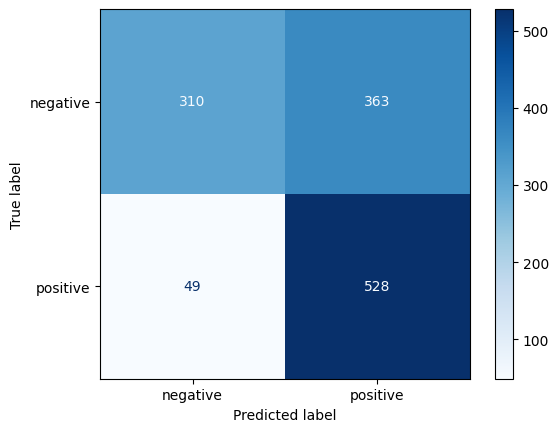

In [60]:
ConfusionMatrixDisplay.from_estimator(
        configs[1]['bst'],
        X_test_en_imdb,
        y_test_en_imdb,
        display_labels=['negative', 'positive'],
        cmap=plt.cm.Blues,
    )

### Random Forest

#### Single example

In [53]:
rf = RandomForestClassifier(max_depth=2)
rf.fit(X_train_en_imdb, y_train_en_imdb)

RandomForestClassifier(max_depth=2)

In [55]:
y_pred = rf.predict(X_test_en_imdb)

accuracy_score(y_test_en_imdb, y_pred), precision_score(y_test_en_imdb, y_pred), recall_score(y_test_en_imdb, y_pred), f1_score(y_test_en_imdb, y_pred)

(0.788, 0.7215909090909091, 0.8804159445407279, 0.7931303669008587)

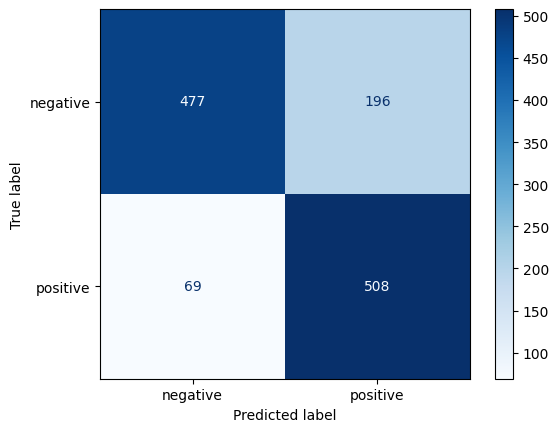

In [56]:
ConfusionMatrixDisplay.from_estimator(
        rf,
        X_test_en_imdb,
        y_test_en_imdb,
        display_labels=['negative', 'positive'],
        cmap=plt.cm.Blues,
    )

#### Generalize

In [68]:
def eval_rf(text_data: list[str], labels: np.ndarray, min_df:float=0.005, max_depth:int=2):
    vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None, min_df=min_df)
    X = vectorizer.fit_transform(text_data).toarray()
    y = labels
    n_tokens = len(vectorizer.get_feature_names_out())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    rf = RandomForestClassifier(max_depth=max_depth)
    start = time()
    rf.fit(X_train, y_train)
    time_took = time() - start

    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1, n_tokens, time_took, vectorizer, rf

In [69]:
configs_rf = [
    {'min_df': .005, 'max_depth': 2},
    {'min_df': .01, 'max_depth': 2},
    {'min_df': .003, 'max_depth': 2},
    {'min_df': .005, 'max_depth': 3},
    {'min_df': .005, 'max_depth': 5},
    {'min_df': .005, 'max_depth': 15},
    {'min_df': .005, 'max_depth': 30},
    {'min_df': .005, 'max_depth': 50},
    {'min_df': .005, 'max_depth': 100}
]

for conf in tqdm(configs_rf):
    results = eval_rf(imdb_en_data, imdb.sentiment.apply(lambda x: x == 'positive').to_numpy().astype(float), **conf)
    conf['accuracy'] = results[0]
    conf['precision'] = results[1]
    conf['recall'] = results[2]
    conf['f1'] = results[3]
    conf['n_tokens'] = results[4]
    conf['time_took'] = results[5]
    conf['vectorizer'] = results[6]
    conf['rf'] = results[7]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.50s/it]


#### Results

In [70]:
pd.DataFrame(configs_rf).drop(columns=['vectorizer', 'rf'])

,min_df,max_depth,accuracy,precision,recall,f1,n_tokens,time_took
0,0.005,2,0.759,0.861862,0.595436,0.704294,2595,0.818156
1,0.010,2,0.716,0.869565,0.514851,0.646766,1565,0.521286
2,0.003,2,0.765,0.849858,0.622407,0.718563,3765,0.605831
3,0.005,3,0.812,0.870416,0.725051,0.791111,2595,0.733033
4,0.005,5,0.804,0.820569,0.766871,0.792812,2595,1.043552
5,0.005,15,0.795,0.775551,0.806250,0.790603,2595,2.184562
6,0.005,30,0.816,0.829114,0.792339,0.810309,2595,3.107246
7,0.005,50,0.814,0.826962,0.804305,0.815476,2595,3.381045
8,0.005,100,0.834,0.866379,0.794466,0.828866,2595,3.638525


## Clusterization (BBC)

In [73]:
bbc_en_data = bbc.content.apply(prepare_en).tolist()

bbc_en_data[:10]

['uk get offici virus alert site rapid alert servic tell home comput user serious internet secur problem launch uk govern servic safe issu warn damag virus softwar vulner weak devic mobil phone alert tell peopl threat affect avoid troubl protect themselv servic free sign get e-mail text alert scheme aim home user small busi govern estim issu secur alert six time year base previous experi virus outbreak clear need easy-to-understand simpl independ advic non-techn mind peopl use comput either home work said home offic minist hazel blear purpos new govern servic ensur comput user awar risk involv deal easili effect without caus alarm sign onli told serious secur threat potenti affect million peopl full-tim staff employ comb mani hundr alert issu year comput secur firm spot one potenti catch larg number peopl alert servic occasion send messag give peopl advic safe way use comput phone safe take technic expertis use help home user understand risk keep comput system mobil phone rang relat co

In [78]:
cluster_vectorizer_en = TfidfVectorizer(tokenizer=word_tokenize, min_df=.01)

vectorized_bbc_en = cluster_vectorizer_en.fit_transform(bbc_en_data).toarray()

cluster_vectorizer_en.get_feature_names_out().shape

(2378,)

In [79]:
vectorized_bbc_en.shape

(2225, 2378)

### K-Means

#### Single example

In [80]:
kmeans_en = KMeans(n_clusters = 2, init = 'k-means++')
kmeans_en.fit_predict(vectorized_bbc_en)

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

In [87]:
kmeans_en.inertia_

2072.4698468175166

#### ELBOW

In [96]:
inertia = []
for k in range(2, 21):
    kmeans_en = KMeans(n_clusters = k, init = 'k-means++')
    kmeans_en.fit(vectorized_bbc_en)
    inertia.append(kmeans_en.inertia_)

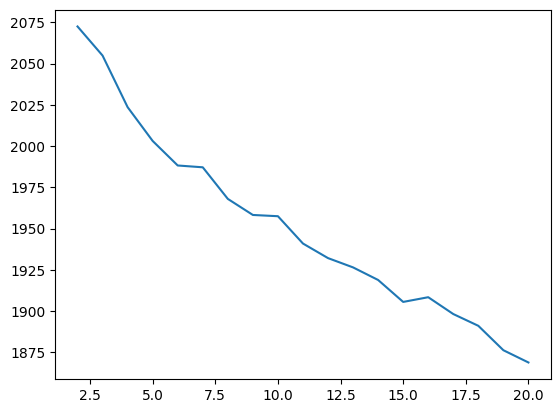

In [97]:
plt.plot(range(2, 21), inertia)
plt.show()

#### Example

In [99]:
kmeans_en = KMeans(n_clusters = 6, init = 'k-means++')
kmeans_en.fit(vectorized_bbc_en)

KMeans(n_clusters=6)

In [100]:
centroids = kmeans_en.cluster_centers_.argsort()[:, ::-1]
for i in range(6):
    terms = [cluster_vectorizer_en.get_feature_names_out()[idx] for idx in centroids[i, :10]]
    print(f'Cluster {i+1}: {" ".join(terms)}')

Cluster 1: said mr govern would law lord minist us say peopl
Cluster 2: bn said bank market compani us firm share growth economi
Cluster 3: game play win player england match said cup club injuri
Cluster 4: use mobil technolog phone peopl said user game comput servic
Cluster 5: mr labour elect parti blair tori brown said tax howard
Cluster 6: film award best star music actor oscar nomin festiv band


### GMM

#### Single example

In [102]:
gmm_en = GaussianMixture(n_components=5)
gmm_en.fit(vectorized_bbc_en)

GaussianMixture(n_components=5)

In [109]:
pd.DataFrame({'content': bbc.content, 'topic': bbc.category, 'cluster': gmm_en.predict(vectorized_bbc_en)}).sample(20)

,content,topic,cluster
2136,Douglas set for Indian adventure Actor Michae...,entertainment,0
1664,GM pays $bn to evade Fiat buyout General Moto...,business,3
1113,Ferguson puts faith in youngsters Manchester ...,sport,4
1256,Bell set for England debut Bath prop Duncan B...,sport,4
608,Final hunts held as ban looms Hunts in Englan...,politics,3
719,Teenagers to be allowed to be MPs Teenagers w...,politics,1
1601,Brazil approves bankruptcy reform A major ref...,business,3
1108,Ireland win eclipses refereeing errors Th...,sport,4
2075,Spector facing more legal action Music produc...,entertainment,3
553,MPs tout Lords replacement plan A group of MP...,politics,1


# Ukrainian

## Generic functions

In [113]:
stemmer = UkStemmer()

incorrect_stopwords = ['рос']

with open('./data/stopwords_ua.txt') as f_stopwords:
    stopwords = [x.replace('\n', '') for x in f_stopwords.readlines()]
    stopwords = [sw for sw in stopwords if sw not in incorrect_stopwords]

num_re = re.compile(r'\d+')
words_re = re.compile(r'\w+')

def prepare_uk(text: str) -> str:
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem_word(t) for t in tokens]
    tokens = [t for t in tokens if t not in punctuation]
    tokens = [t for t in tokens if t not in stopwords]
    tokens = [t for t in tokens if num_re.match(t) is None]
    tokens = [t for t in tokens if words_re.match(t) is not None]

    return ' '.join(tokens)

## Classification (IMDB)

### XGBoost

In [114]:
imdb_uk_data = imdb.review_uk.apply(prepare_uk).tolist()
imdb_uk_data[:10]

['щойн побач сайт showtime wwwwwwwww навіт жарт поган фільм одн найшкідливіш вибух монстр коли-небуд бач тог телевізійн репортер фільм дратув джер минул сезон виживанн єдин кумедн річч бул таємн бул будинок fantasy isy мільйон інш фільм телешоу-шо місц знаходит район лос-',
 'незабутн французьк хлопчик матіе jermie elkaim відпустц влітк зустріч закохуєт седрик красив stephane radau повільн фільм дуж неприємн одн бок поглинут відчув почутт хлопц',
 'дружин помітил фільм одн проход місцев магазин віде обкладинк вигляд науково-фантастичн фільм ал післ тог йог перевернул дружин побачил фільм християнськ фільм зрозуміл незабутн фільм йог бачил',
 'див фільм hbo мав добр br br режисер зроб велик робот повніст поглинут фільм одраз післ тог розпоч норман рідус гра дуж крут фільм br br br настільк поглинут обставин хот захопит пістолет норман знят дівчину- змі he мен подобают фільм кол невинн дівчат грают чоловік дуж хитр кінец чог хот br br фільм наповнен деформаційн момент очікуєт станет ал і

#### Generalize

In [116]:
configs_uk = [
    {'min_df': .005, 'n_estimators': 2, 'max_depth': 3},
    {'min_df': .01, 'n_estimators': 2, 'max_depth': 3},
    {'min_df': .003, 'n_estimators': 2, 'max_depth': 3},
    {'min_df': .005, 'n_estimators': 10, 'max_depth': 3},
    {'min_df': .005, 'n_estimators': 2, 'max_depth': 7},
    {'min_df': .005, 'n_estimators': 100, 'max_depth': 3},
    {'min_df': .005, 'n_estimators': 200, 'max_depth': 3},
    {'min_df': .005, 'n_estimators': 100, 'max_depth': 5},
]

for conf in tqdm(configs_uk):
    results = eval_xgboost(imdb_uk_data, imdb.sentiment.apply(lambda x: x == 'positive').to_numpy().astype(float), **conf)
    conf['accuracy'] = results[0]
    conf['precision'] = results[1]
    conf['recall'] = results[2]
    conf['f1'] = results[3]
    conf['n_tokens'] = results[4]
    conf['time_took'] = results[5]
    conf['vectorizer'] = results[6]
    conf['bst'] = results[7]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.26s/it]


#### Results

In [117]:
pd.DataFrame(configs_uk).drop(columns=['vectorizer', 'bst'])

,min_df,n_estimators,max_depth,accuracy,precision,recall,f1,n_tokens,time_took
0,0.005,2,3,0.634,0.586902,0.924603,0.718028,1212,0.318136
1,0.010,2,3,0.623,0.571782,0.937120,0.710223,662,0.075038
2,0.003,2,3,0.618,0.561783,0.920668,0.697785,1948,0.209886
3,0.005,10,3,0.649,0.612598,0.787449,0.689105,1212,0.380600
4,0.005,2,7,0.649,0.593575,0.876289,0.707744,1212,0.268710
5,0.005,100,3,0.695,0.681275,0.702259,0.691608,1212,0.828508
6,0.005,200,3,0.728,0.693798,0.758475,0.724696,1212,1.957051
7,0.005,100,5,0.709,0.695565,0.711340,0.703364,1212,1.610176


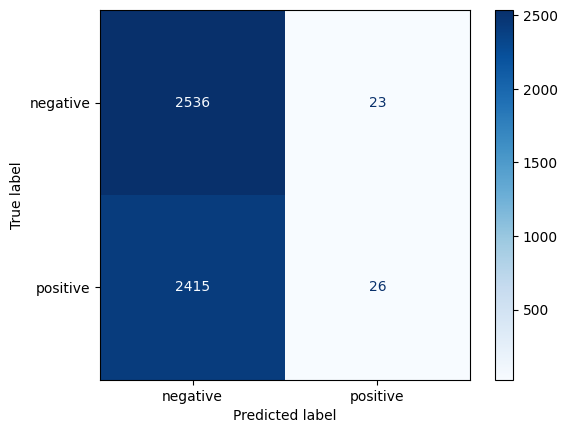

In [125]:
ConfusionMatrixDisplay.from_estimator(
        configs_uk[6]['bst'],
        configs_uk[6]['vectorizer'].transform(imdb_uk_data),
        imdb.sentiment.apply(lambda x: x == 'positive').to_numpy().astype(float),
        display_labels=['negative', 'positive'],
        cmap=plt.cm.Blues,
    )

### Random forest

#### Generalize

In [126]:
configs_rf_uk = [
    {'min_df': .005, 'max_depth': 2},
    {'min_df': .01, 'max_depth': 2},
    {'min_df': .003, 'max_depth': 2},
    {'min_df': .005, 'max_depth': 3},
    {'min_df': .005, 'max_depth': 5},
    {'min_df': .005, 'max_depth': 15},
    {'min_df': .005, 'max_depth': 30},
    {'min_df': .005, 'max_depth': 50},
    {'min_df': .005, 'max_depth': 100}
]

for conf in tqdm(configs_rf_uk):
    results = eval_rf(imdb_uk_data, imdb.sentiment.apply(lambda x: x == 'positive').to_numpy().astype(float), **conf)
    conf['accuracy'] = results[0]
    conf['precision'] = results[1]
    conf['recall'] = results[2]
    conf['f1'] = results[3]
    conf['n_tokens'] = results[4]
    conf['time_took'] = results[5]
    conf['vectorizer'] = results[6]
    conf['rf'] = results[7]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.87s/it]


#### Results

In [127]:
pd.DataFrame(configs_rf_uk).drop(columns=['vectorizer', 'rf'])

,min_df,max_depth,accuracy,precision,recall,f1,n_tokens,time_took
0,0.005,2,0.675,0.782443,0.433404,0.557823,1212,0.680328
1,0.010,2,0.607,0.827411,0.312261,0.453408,662,0.478406
2,0.003,2,0.628,0.842697,0.303644,0.446429,1948,0.670624
3,0.005,3,0.676,0.594640,0.812357,0.686654,1212,0.684002
4,0.005,5,0.720,0.800562,0.576923,0.670588,1212,0.659263
5,0.005,15,0.723,0.750000,0.677228,0.711759,1212,1.407890
6,0.005,30,0.719,0.737634,0.683267,0.709411,1212,2.200821
7,0.005,50,0.722,0.744086,0.685149,0.713402,1212,2.531185
8,0.005,100,0.710,0.709877,0.698381,0.704082,1212,2.942249


## Clusterization (BBC)

In [129]:
bbc_uk_data = bbc.content_uk.apply(prepare_uk).tolist()

bbc_uk_data[:10]

['дан програмн забезпеченн працюют інформаційн мереж можут прослідкув інформаційн мереж можут надав інформац небезпек можут вплив можут зробит уникнут пробл захистит себ',
 'продавец фішк знов телефон rich tempton голов гігантськ механізм створенн мікросхем техас підтримк зростаюч сектор голос інтернет телефон віп вайп дозвол користувач пк деяк випадк мают звязок широк мереже зробит телефонн звязок мереж містер темплтон сказ voip буд наступн основн застосуванн доставит звязк інтернет приміщенн інтернет wanadboy безкоштовн телефонн звязок інш споживач буд коштув xa',
 'провідник працюют вдом памятают наз зробит люд мают мікрофонн програмн забезпеченн робл ціє технік робл отримуют інформац хочет хочет хочет',
 'шуд музик вест мобільн телефон насолоджуют відбуваєт сфер продаж відповідн досліджен аналітик мільйон мобільн телефон бул продан минул рок всьом світ сказ найвищ загальн інформац цифр бул інтернет перевищил навіт найоптимістичн прогноз гартнер сказ достойн дизайн вигляд мобільн те

In [130]:
cluster_vectorizer_uk = TfidfVectorizer(tokenizer=word_tokenize, min_df=.01)

vectorized_bbc_uk = cluster_vectorizer_uk.fit_transform(bbc_uk_data).toarray()

cluster_vectorizer_uk.get_feature_names_out().shape

/mnt/e/university/master/text_analysis-labs/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(721,)

### K-Means

#### ELBOW

In [131]:
inertia_uk = []
for k in range(2, 21):
    kmeans_uk = KMeans(n_clusters = k, init = 'k-means++')
    kmeans_uk.fit(vectorized_bbc_uk)
    inertia_uk.append(kmeans_uk.inertia_)

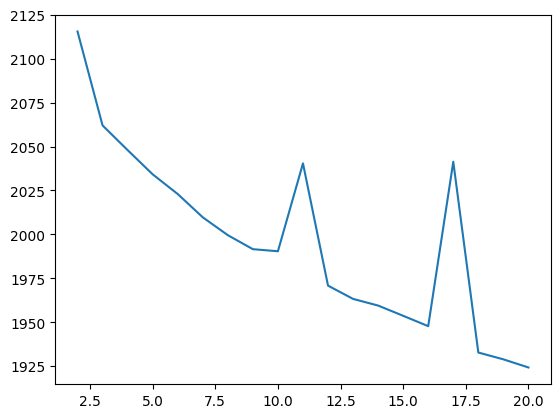

In [132]:
plt.plot(range(2, 21), inertia_uk)
plt.show()

#### Example

In [133]:
kmeans_uk = KMeans(n_clusters = 9, init = 'k-means++')
kmeans_uk.fit(vectorized_bbc_uk)

KMeans(n_clusters=9)

In [134]:
centroids_uk = kmeans_uk.cluster_centers_.argsort()[:, ::-1]
for i in range(9):
    terms = [cluster_vectorizer_uk.get_feature_names_out()[idx] for idx in centroids_uk[i, :10]]
    print(f'Cluster {i+1}: {" ".join(terms)}')

Cluster 1: мереж мобільн сайт інтернет люд телефон можут компютер систем користувач
Cluster 2: бул сказ тог ал якщ том рок компані післ йог
Cluster 3: рок перш ал вигр останн перемог друг минул кол олімпійськ
Cluster 4: the to of and in for on a is it
Cluster 5: фільм найкращ актор оскар бул фестивал плівк зірк рол сша
Cluster 6: нов компані сказ будут бул фірм уряд план сво питан
Cluster 7: сказ йог післ ал тог кол англі буд бул отрим
Cluster 8: сказ вибор говард браун премєр-міністр лідер тон тор йог блеєр
Cluster 9: сша банк продаж bn цін зростанн економік бул xc рок


### GMM

#### Single example

In [136]:
gmm_uk = GaussianMixture(n_components=5)
gmm_uk.fit(vectorized_bbc_uk)

GaussianMixture(n_components=5)

In [137]:
pd.DataFrame({'content': bbc.content_uk, 'topic': bbc.category, 'cluster': gmm_uk.predict(vectorized_bbc_uk)}).sample(20)

,content,topic,cluster
1457,Ірландські ринки збільшуються до всіх частих і...,business,2
1374,"Німеччина, майже безробітний рівень роботи, пі...",business,2
331,"BT програма, щоб подолати Симптоми додзвону, В...",tech,0
2069,Британські зірки відреклися від премії великих...,entertainment,1
208,"Ігри в онлайн-ігри після того, як з'явилися он...",tech,1
243,Прогрес на нових доменах інтернету Спочатку ця...,tech,0
1492,Згідно з даними Національного товариства будів...,business,2
409,"Келлі стежила за новою дисципліною вчителів, щ...",politics,3
1971,"Пізно, щоб зірка в Бродвеї Актор Християнський...",entertainment,1
37,"Проінформувавши сайт Дживс, який став дуже поп...",tech,0
